In [ ]:
!pip install transformers
!pip install datasets[audio]
!pip install transformers[torch]
!pip install accelerate>=0.20.1
!pip install git+https://github.com/huggingface/transformers

      Successfully uninstalled transformers-4.35.2


In [ ]:
import numpy as np

In [ ]:
!pip install wandb

import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
os.environ["WANDB_PROJECT"]="chorddetectionwhisper"

In [ ]:
# Cargando el paquete de Colab para usar drive
from google.colab import drive

# Montar el colab en drive (Requiere autorización de Google Drive)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset

In [ ]:
ds_train = load_dataset("audiofolder", data_dir="//content/drive/MyDrive/Tesis/acordes_completo/train")

Resolving data files:   0%|          | 0/30243 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#ds_test = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/Tesis/acordes_completo/test")

In [ ]:
from transformers import AutoFeatureExtractor

model_id = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

In [ ]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [ ]:
sample = ds_train["train"][0]["audio"]

print(f"Mean: {np.mean(sample['array']):.3}, Variance: {np.var(sample['array']):.3}")

Mean: -2.71e-05, Variance: 0.0105


In [ ]:
inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])

print(f"inputs keys: {list(inputs.keys())}")

print(
    f"Mean: {np.mean(inputs['input_values']):.3}, Variance: {np.var(inputs['input_values']):.3}"
)

inputs keys: ['input_values', 'attention_mask']
Mean: 2.74e-09, Variance: 1.0


In [ ]:
max_duration = 4.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [ ]:
ds_train_encoded = ds_train.map(
    preprocess_function,
    remove_columns=["audio"],
    batched=True,
    batch_size=100,
    num_proc=1,
)
ds_train_encoded

Map:   0%|          | 0/30243 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 30243
    })
})

In [ ]:
#guardar los resultados del encode para no tener que preprocesar siempre
ds_train_encoded.save_to_disk('/content/drive/MyDrive/Tesis/dataproces/train2')

Saving the dataset (0/31 shards):   0%|          | 0/30243 [00:00<?, ? examples/s]

In [ ]:
train_encoded = load_dataset('/content/drive/MyDrive/Tesis/dataproces/train2')

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 30243
    })
})

In [ ]:
train_encoded = train_encoded["train"].train_test_split(seed=42, shuffle=True, test_size=0.2)

In [ ]:
id2label_fn = train_encoded["train"].features["label"].int2str
id2label_fn(train_encoded["train"][0]["label"])

'SolDisminuida'

In [ ]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(train_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label["7"]

'FaMenor'

In [ ]:
from transformers import AutoModelForAudioClassification

num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 8
gradient_accumulation_steps = 1
num_train_epochs = 10

In [ ]:
training_args = TrainingArguments(
    f"{model_name}-finetuned-chorddetection2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_encoded["train"],
    eval_dataset=train_encoded["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: Currently logged in as: alejogil1693 (chorddetection). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.575300,0.507428,0.910068
2,0.000900,0.005751,0.998512
3,0.000100,0.001059,0.999669


In [ ]:
kwargs = {
     "dataset_tags" : "acordes_completo" ,
     "dataset" : "ChordStimation2" ,
     "model_name" : f"{model_name}-finetuned-chorddetection2" ,
     "finetuned_from" : model_id,
     "tasks" : "clasificación de acordes "
}

In [ ]:
trainer.push_to_hub(**kwargs)

'https://huggingface.co/alejogil35/distilhubert-finetuned-chorddetection2/tree/main/'

In [ ]:
from transformers import pipeline

pipe = pipeline(
    "audio-classification", model="alejogil35/distilhubert-finetuned-chorddetection2"
)

In [ ]:
ds_test = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/Tesis/dataproces/train")

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/32 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
ds_test

DatasetDict({
    train: Dataset({
        features: ['audio'],
        num_rows: 0
    })
})

In [ ]:
ds_test = ds_test.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
ds_test['train']

Dataset({
    features: ['audio'],
    num_rows: 13
})

In [ ]:
from transformers import AutoFeatureExtractor

model_id = "alejogil35/distilhubert-finetuned-chorddetection2"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)

In [ ]:
sample = ds_test["train"][0]["audio"]
sample

{'path': '/content/drive/MyDrive/Tesis/acordes_guitarra/DoMaj3P.wav',
 'array': array([-0.00242025, -0.00911479, -0.01501505, ...,  0.        ,
         0.        ,  0.        ]),
 'sampling_rate': 16000}

In [ ]:
sample = ds_test["train"][0]["audio"]

print(f"Mean: {np.mean(sample['array']):.3}, Variance: {np.var(sample['array']):.3}")

Mean: -1.82e-05, Variance: 0.0113


In [ ]:
inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])

print(f"inputs keys: {list(inputs.keys())}")

print(
    f"Mean: {np.mean(inputs['input_values']):.3}, Variance: {np.var(inputs['input_values']):.3}"
)

inputs keys: ['input_values', 'attention_mask']
Mean: -5.31e-09, Variance: 1.0


In [ ]:
inputs['input_values']

[array([-0.02258147, -0.08551662, -0.1409847 , ...,  0.00017121,
         0.00017121,  0.00017121], dtype=float32)]

In [ ]:
max_duration = 4.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [ ]:
ds_test_encode = ds_test.map(
    preprocess_function,
    batched=True,
    batch_size=100,
    num_proc=1,)

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

In [ ]:
sample = ds_test_encode["train"][0]["audio"]

print(f"Mean: {np.mean(sample['array']):.3}, Variance: {np.var(sample['array']):.3}")

Mean: -3.32e-05, Variance: 0.0113


In [ ]:
example["audio"]["array"]

array([-0.00444473, -0.01734339, -0.02456249, ...,  0.        ,
        0.        ,  0.        ])

In [ ]:
example = ds_test['train'][1]
pipe(inputs['input_values'])

[[{'score': 0.8280677795410156, 'label': 'MiMenor'},
  {'score': 0.100166916847229, 'label': 'DoMenor'},
  {'score': 0.0682237297296524, 'label': 'ReBemolMayor'},
  {'score': 0.0010341783054172993, 'label': 'DoMayor'},
  {'score': 0.0008735913434065878, 'label': 'ReBemolMenor'}]]

In [ ]:
example

{'audio': {'path': '/content/drive/MyDrive/Tesis/acordes_guitarra/DoMaj4P.wav',
  'array': array([-0.00444473, -0.01734339, -0.02456249, ...,  0.        ,
          0.        ,  0.        ]),
  'sampling_rate': 16000}}

In [ ]:
test2 = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/Tesis/acordes_prueba")

Resolving data files:   0%|          | 0/480 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
test2['train']['audio'][0]

{'path': '/content/drive/MyDrive/Tesis/acordes_prueba/DoMayor/Do1.wav',
 'array': array([-0.00349426, -0.00997925, -0.01472473, ...,  0.        ,
         0.        ,  0.        ]),
 'sampling_rate': 44100}

In [ ]:
from datasets import Audio

In [ ]:
test2 = test2.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
test2['train']['audio'][0]

{'path': '/content/drive/MyDrive/Tesis/acordes_prueba/DoMayor/Do1.wav',
 'array': array([-0.00390445, -0.01716476, -0.03000646, ...,  0.        ,
         0.        ,  0.        ]),
 'sampling_rate': 16000}

In [ ]:
example = test2['train'][200]
result = pipe(example["audio"]["array"])

In [ ]:
result[0]['label']

'SiDisminuida'

In [ ]:
example

{'audio': {'path': '/content/drive/MyDrive/Tesis/acordes_prueba/MiMayor/Mi1.wav',
  'array': array([-0.00199511, -0.00824417, -0.01717512, ...,  0.        ,
          0.        ,  0.        ]),
  'sampling_rate': 16000},
 'label': 10}

In [ ]:
sample1 = ds_test['train'][2]
sample1

{'audio': {'path': '/content/drive/MyDrive/Tesis/acordes_guitarra/DoMaj5P.wav',
  'array': array([-0.00244141, -0.00662231, -0.00942993, ...,  0.        ,
          0.        ,  0.        ]),
  'sampling_rate': 44100}}

In [ ]:
sample2 = ds_test['train'][12]
sample2

{'audio': {'path': '/content/drive/MyDrive/Tesis/acordes_guitarra/piano_3_Cn_a_f_80.wav',
  'array': array([0.        , 0.        , 0.        , ..., 0.        , 0.00012207,
         0.00018311]),
  'sampling_rate': 16000}}

In [ ]:
import torchaudio
import matplotlib.pyplot as plt

In [ ]:
sample1['audio']['path']

'/content/drive/MyDrive/Tesis/acordes_guitarra/DoMaj5P.wav'

In [ ]:
audio_path = sample1['audio']['path']
audio, sample_rate = torchaudio.load(audio_path)

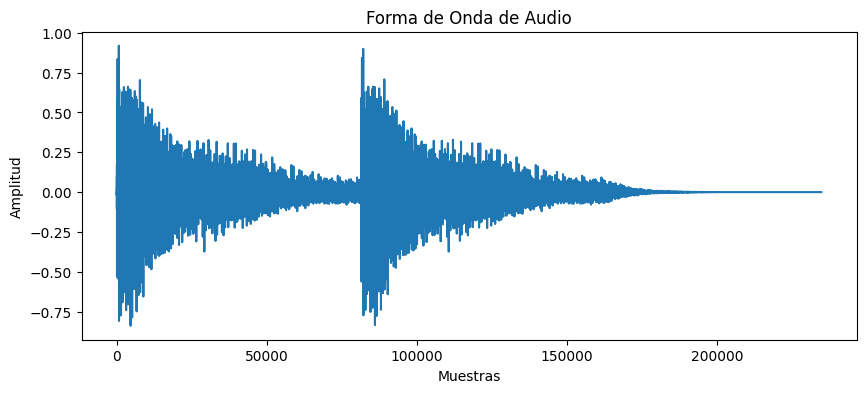

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(audio[0].t().numpy())
plt.title("Forma de Onda de Audio")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.show()

In [ ]:
waveform, sample_rate = torchaudio.load(audio_path)

In [ ]:
duracion_muestras = int(1.7 * sample_rate)

In [ ]:
waveform_recortado = waveform[:, :duracion_muestras]

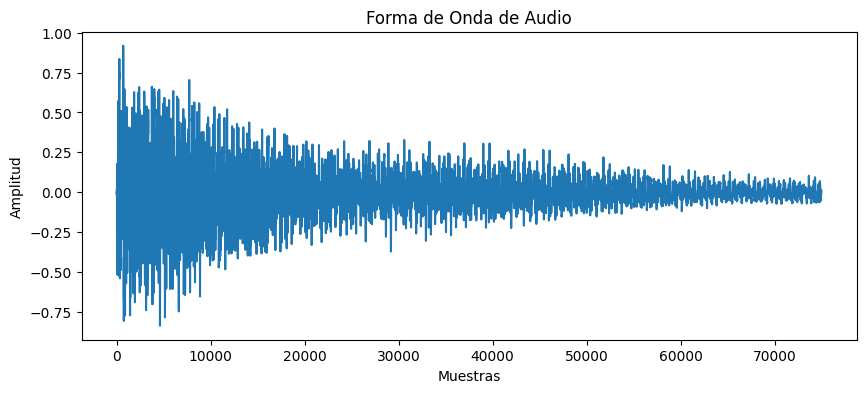

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(waveform_recortado[0].t().numpy())
plt.title("Forma de Onda de Audio")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.show()

In [ ]:
pipe(waveform_recortado[0].t().numpy())

[{'score': 0.9623990654945374, 'label': 'DoMenor'},
 {'score': 0.03702957183122635, 'label': 'MiBemolDisminuida'},
 {'score': 0.00024282964295707643, 'label': 'LaDisminuida'},
 {'score': 0.0001924158277688548, 'label': 'ReBemolMayor'},
 {'score': 9.377133392263204e-05, 'label': 'MiMenor'}]

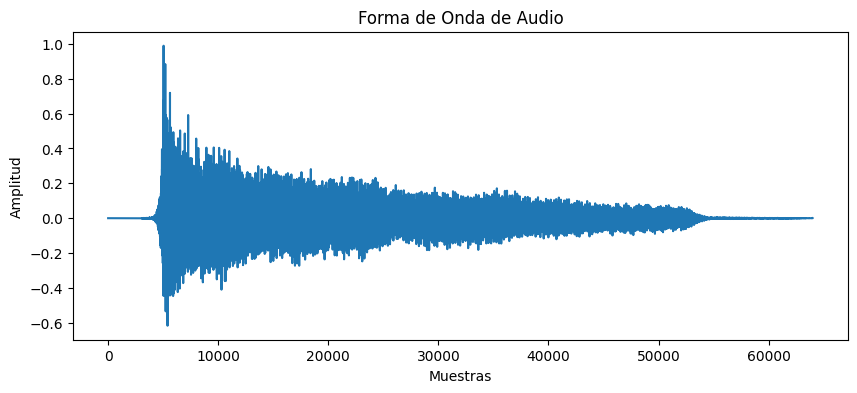

In [ ]:
audio_path = sample2['audio']['path']
audio, sample_rate = torchaudio.load(audio_path)
plt.figure(figsize=(10, 4))
plt.plot(audio.t().numpy())
plt.title("Forma de Onda de Audio")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.show()

In [ ]:
train_encoded['train'][0]['input_values']

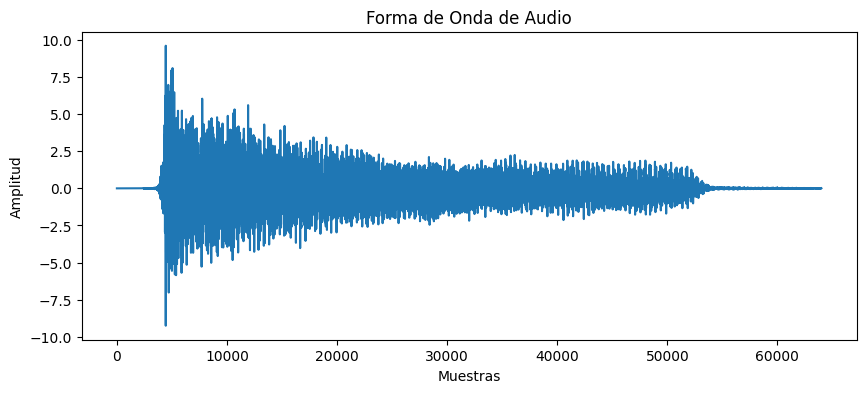

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_encoded['train'][0]['input_values'])
plt.title("Forma de Onda de Audio")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.show()

In [ ]:
ds_train_prepoc = load_dataset('/content/drive/MyDrive/Tesis/dataOtherMoldels/trainspect')

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
ds_train_prepoc['train'][2000]['input_features'][0][0]

[-0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.6875543594360352,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.9591071605682373,
 -0.7512695789337158,
 -0.7623085975646973,
 -0.7805969715118408,
 -0.8903840780258179,
 -0.6146575212478638,
 -0.4241034984588623,
 -0.12593257427215576,
 0.09272748231887817,
 0.19685816764831543,
 0.1808759570121765,
 0.5548261404037476,
 0.7524884939193726,
 0.7034671306610107,
 0.3201766610145569,
 0.4186062812805176,
 0.32717442512512207,
 0.390704870223999,
 0.43286246061325073,
 0.41916054487228394,
 0.1837950348854065,
 0.3876596689224243,
 0.048443734645843506,
 0.4389228820800781,
 0.3743399977684021,
 0.25308382511138916

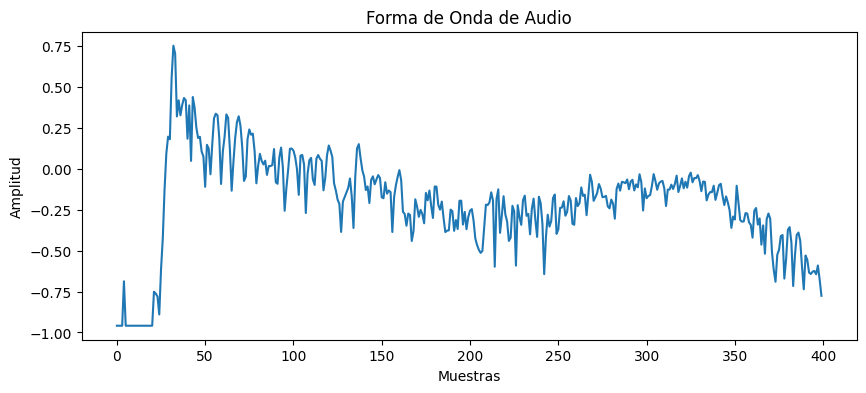

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ds_train_prepoc['train'][2000]['input_features'][0][0])
plt.title("Forma de Onda de Audio")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.show()